# **TPS 7 — Etchepareborda Baltazar Ariel - Aprendizaje no supervisado**

In [338]:
#Importaciones iniciales, solo las que nos dejan usar (scipy no).
import numpy as np
import matplotlib.pyplot as plt

Comentario: Por un tema de aleatoriedad de los datos (logicamente), las muestras generadas puede ser que justo no sean perfectamente representativas de la geometria que se busca proyectar de la M con el manifold para construir y reconstruir, en promedio, las cosas dan bien. Pero alguna vez le di a run all y puede que la M de la nube de puntos no se genere bien y se ajuste mal los centroides, el EM etc...

#**Punto a: Creacion del dataset**
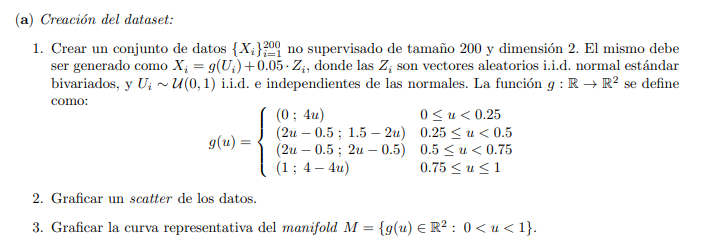

In [339]:
#Defino una funcion para devolver g(u) de abajo, toma las entradas uniformes y devuelve el vector de dos dimensiones.
def g(u):
    u = np.asarray(u)
    x = np.zeros_like(u)
    y = np.zeros_like(u)

    # tramo 1
    mask1 = (u >= 0.0) & (u < 0.25) #La primer indicadora
    x[mask1] = 0.0
    y[mask1] = 4.0 * u[mask1]
    # tramo 2:
    mask2 = (u >= 0.25) & (u < 0.5) #La segunda indicadora
    x[mask2] = 2.0*u[mask2] - 0.5
    y[mask2] = 1.5 - 2.0*u[mask2]
    # tramo 3
    mask3 = (u >= 0.5) & (u < 0.75) #idem
    x[mask3] = 2.0*u[mask3] - 0.5
    y[mask3] = 2.0*u[mask3] - 0.5
    # tramo 4:
    mask4 = (u >= 0.75) & (u <= 1.0)#idem
    x[mask4] = 1.0
    y[mask4] = 4.0 - 4.0*u[mask4]

    return np.vstack([x, y]).T  # shape (N,2)


# **TPS 7 — Punto (a): Generación de los datos**

En este primer punto buscamos **generar un conjunto de datos no supervisado** formado por 200 muestras bidimensionales $X_i $, cada una proveniente de una **curva paramétrica con ruido gaussiano**.

---

## **(a).1 Definición del modelo de datos**

Cada muestra se genera como:

$$
X_i = g(U_i) + 0.05 \cdot Z_i, \quad i = 1, 2, \dots, 200
$$

donde:

- $ U_i \sim \mathcal{U}(0, 1) $ son variables aleatorias uniformes.
- $ Z_i \sim \mathcal{N}(0, I_2)$ son vectores aleatorios gaussianos estándar en $\mathbb{R}^2 $, **independientes** entre sí.
- $g : \mathbb{R} \to \mathbb{R}^2$ es una función **por tramos**, que define una **curva poligonal** en el plano.

---

## **(a).2 Definición de la curva \( g(u) \)**

La función $ g(u) $ se define como:

$$
g(u) =
\begin{cases}
(0,\; 4u) & \text{si } 0 \le u < 0.25 \\\\
(2u - 0.5,\; 1.5 - 2u) & \text{si } 0.25 \le u < 0.5 \\\\
(2u - 0.5,\; 2u - 0.5) & \text{si } 0.5 \le u < 0.75 \\\\
(1,\; 4 - 4u) & \text{si } 0.75 \le u \le 1
\end{cases}
$$

Cada tramo representa un **segmento lineal** de la curva.  
Por lo tanto, $M = \{ g(u) : 0 < u < 1 \}$ forma una **curva quebrada** (polilínea) que será el **manifold verdadero** sobre el cual se distribuyen los datos.


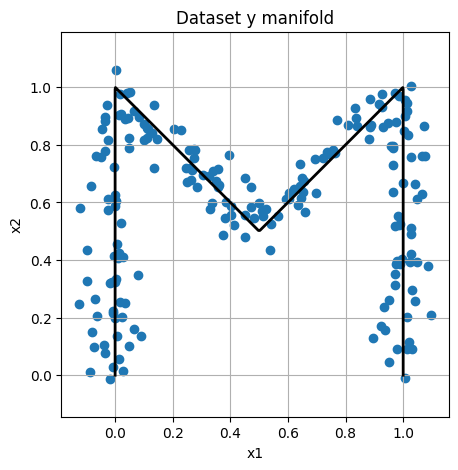

In [340]:
N = 200
U = np.random.rand(N) #armo la unforme
Z = np.random.randn(N, 2)  # armo la normal
G = g(U)  #Le paso la uniforme base
X = G + 0.05 * Z  # Le sumo el ruido a la transformacion de la uniforme
#Grafico el scatter del punto dos y lo junto con la M pura (sin ruido)
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.title("Dataset y manifold")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid(True)

u_curve = np.linspace(0, 1, 400)
M = g(u_curve)
plt.plot(M[:,0], M[:,1], 'k-', linewidth=2)  # Curva representativa del manifold
plt.show()


Como el espacio latente Z a la que las variables se codifican (de 2 a 1) y la dimension de destino es menor a la direccion de origen con una reduccion de dimensionalidad no lineal, se habla de manifold.

Se genera el conjunto de puntos ruidosos $ X_i $ y se los grafica en un scatterplot.Estos representan las observaciones reales que tendremos disponibles. Se grafica la curva ideal $ M $, sin ruido, para visualizar el manifold subyacente (pasar de 2 dimensiones y una buena representacion a 1 dimension como su proyeccion sobre estas rectas).

## **(b) K-Means**


Se busca dividir los datos $ X_i \in \mathbb{R}^2 $ en $ K $ grupos, de forma que cada grupo contenga puntos pertenecientes a un mismo tramo aproximadamente recto de la curva.

---

### Modelo

K-Means busca minimizar la suma de distancias cuadradas entre cada punto y su centroide:

$$
J = \sum_{i=1}^{N} \min_{k} \| X_i - \mu_k \|^2
$$

donde:
- $ \mu_k $ es el centroide del cluster $ k $,
- $ c(i) $ es el índice del cluster asignado al punto $ i $.

---


### Algoritmo

1. **Inicialización:**  
   Seleccionar $ K $ puntos aleatorios del dataset como centroides iniciales.

2. **Etapa de asignación:**  
   Para cada punto  $ X_i $ :
   $$
   c(i) = \arg\min_k \| X_i - \mu_k \|^2
   $$

3. **Etapa de actualización:**  
   Recalcular los centroides:
   $$
   \mu_k = \frac{1}{N_k} \sum_{i: c(i)=k} X_i
   $$

4. **Repetir** hasta convergencia.

---


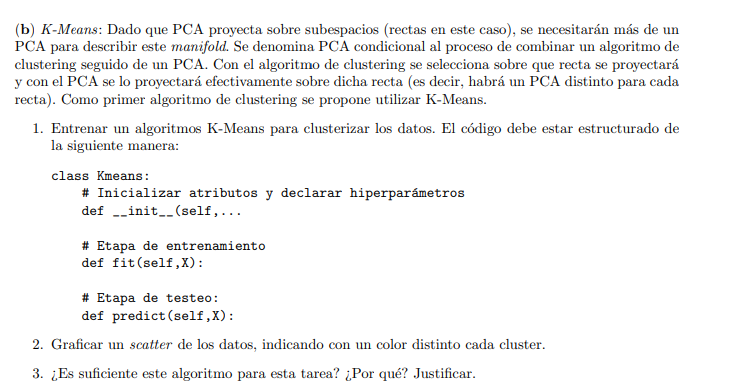

In [341]:
class KMeans:
    def __init__(self, K=4, max_iters=100, tol=1e-4, seed=None):
        """
        Inicializa los hiperparámetros del algoritmo.
        K: cantidad de clusters
        max_iters: iteraciones máximas
        tol: criterio de convergencia (en distancia de centroides)
        seed: semilla para reproducibilidad
        """
        self.K = K
        self.max_iters = max_iters
        self.tol = tol
        self.seed = seed

        # Parámetros aprendidos
        self.centroids = None

    def fit(self, X):
        """
        Etapa de entrenamiento:
        Calcula los centroides finales que minimizan la distancia euclídea total.
        """
        rng = np.random.default_rng(self.seed)
        N, D = X.shape

        # Inicialización aleatoria de centroides
        idx = rng.choice(N, size=self.K, replace=False)
        self.centroids = X[idx, :].copy()

        for it in range(self.max_iters):
            # --- Asignación ---
            diff = X[:, None, :] - self.centroids[None, :, :]  # (N,K,D)
            dist_sq = np.sum(diff**2, axis=2)  # (N,K)
            labels = np.argmin(dist_sq, axis=1)  # (N,)

            # --- Actualización ---
            new_centroids = np.zeros_like(self.centroids)
            for k in range(self.K):
                pts = X[labels == k]
                if len(pts) > 0:
                    new_centroids[k] = np.mean(pts, axis=0)
                else:
                    # Reasignar centroid vacío
                    new_centroids[k] = X[rng.integers(0, N)]

            # --- Criterio de convergencia ---
            shift = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            if shift < self.tol:
                break

        self.labels_ = labels

    def predict(self, X):
        """
        Etapa de testeo: asigna cada punto al cluster más cercano.
        """
        diff = X[:, None, :] - self.centroids[None, :, :]
        dist_sq = np.sum(diff**2, axis=2)
        labels = np.argmin(dist_sq, axis=1)
        return labels


2. Graficar un scatter de los datos, indicando con un color distinto cada cluster.

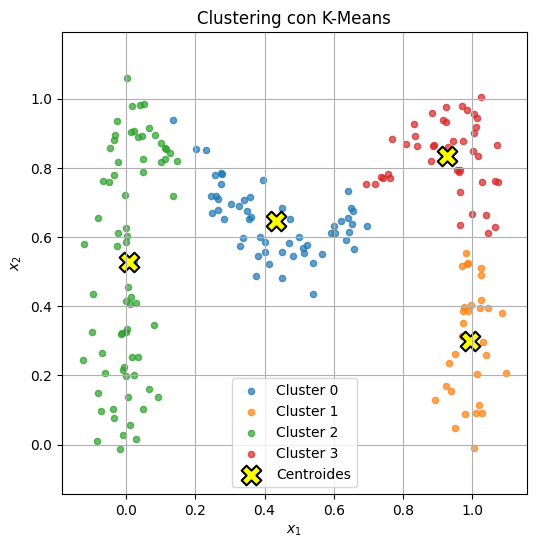

In [342]:
# Entreno K-Means
kmeans = KMeans(K=4, max_iters=200, tol=1e-5, seed=None)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.centroids


plt.figure(figsize=(6,6))
for k in range(kmeans.K):
    pts = X[labels == k]
    plt.scatter(pts[:,0], pts[:,1], s=20, alpha=0.7, label=f"Cluster {k}")

plt.scatter(centroids[:,0], centroids[:,1],
            marker='X', s=200, facecolor='yellow', edgecolor='k', linewidth=1.5,
            label='Centroides')
plt.title("Clustering con K-Means")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()



En el gráfico se muestran:
- Los puntos $ X_i $ coloreados según su cluster.
- Los centroides $ \mu_k $ (✕ amarillas).




---

### 3. ¿Es suficiente este algoritmo para esta tarea? ¿Por que? Justificar.

Aunque K-Means permite segmentar los datos, no es suficiente para describir correctamente este manifold:

- No modela la orientación local de los tramos.  
- No puede capturar estructuras curvadas o estiradas, no varia la covarianza.

Por eso, en el siguiente paso se reemplaza por el algoritmo EM (Expectation–Maximization), que utiliza mezclas gaussianas con covarianzas completas para describir clusters elípticos y orientados.



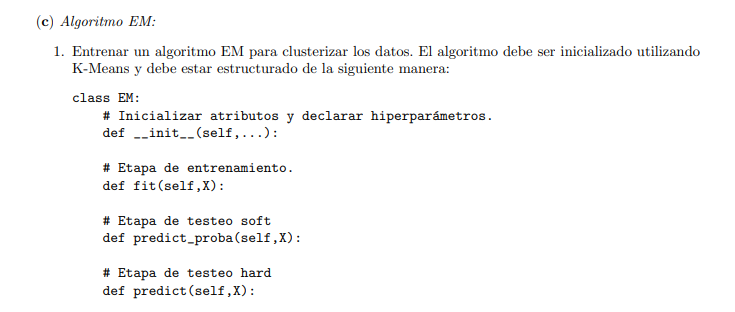

## (c) Algoritmo EM (Expectation–Maximization)

El modelo de mezcla de gaussianas (GMM) entrenado con el algoritmo EM permite representar datos que provienen de múltiples distribuciones subyacentes.  
A diferencia de métodos como K-Means, que asume que cada punto pertenece de forma rígida a un solo grupo, EM asigna probabilidades de pertenencia a cada cluster, capturando incertidumbre y solapamiento entre regiones del espacio de datos.

Esto le permite modelar estructuras complejas donde:
- Los clusters pueden tener formas elípticas .
- Las regiones de datos pueden superponerse parcialmente.
- Cada componente puede tener su propia dispersión y orientación (covarianza diferente).

EM combina varios modelos gaussianos para describir los datos de manera probabilística, logrando una representación más flexible de las distribuciones que generan las observaciones.



#### **Paso E**
Se calcula la probabilidad de que cada muestra $ x_i $ pertenezca a cada componente $ k $:
$$
r_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}
               {\sum_j \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
$$

#### **Paso M**
Con esas probabilidades, se actualizan los parámetros del modelo:
$$
\pi_k = \frac{N_k}{N}, \quad
\mu_k = \frac{1}{N_k} \sum_i r_{ik} x_i, \quad
\Sigma_k = \frac{1}{N_k} \sum_i r_{ik} (x_i - \mu_k)(x_i - \mu_k)^\top
$$
donde $N_k = \sum_i r_{ik} $ es el “peso efectivo” de cada cluster.

---

In [343]:
class EM:
    def __init__(self, K=4, max_iters=100, tol=1e-4, seed=None):
        """
        Inicializa los hiperparámetros del algoritmo EM.
        """
        self.K = K
        self.max_iters = max_iters
        self.tol = tol
        self.seed = seed

        # Parámetros aprendidos
        self.pi = None        # pesos mezcla
        self.mu = None        # medias
        self.Sigma = None     # covarianzas
        self.log_likelihood = []

    def _initialize(self, X):
        rng = np.random.default_rng(self.seed)
        N, D = X.shape
        #Uso la clase que ya me arme de antes
        km = KMeans(K=self.K, max_iters=100, tol=1e-4, seed=self.seed)
        km.fit(X)
        self.mu = km.centroids.copy()
        # Covarianzas iniciales: identidad pequeña
        self.Sigma = np.array([np.eye(D) * 0.05 for _ in range(self.K)])
        # Pesos mezcla: proporción de puntos en cada cluster
        counts = np.array([np.sum(km.labels_ == k) for k in range(self.K)])
        self.pi = counts / N
    #Armo la normal
    def _gaussian_pdf(self, X, mu, Sigma):
        D = X.shape[1]
        det = np.linalg.det(Sigma)
        inv = np.linalg.inv(Sigma)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**D * det)
        diff = X - mu
        expo = -0.5 * np.sum(diff @ inv * diff, axis=1)
        return norm_const * np.exp(expo)
    #Entreno el modelo
    def fit(self, X):
        N, D = X.shape
        self._initialize(X)

        for it in range(self.max_iters):
            r = np.zeros((N, self.K))
            for k in range(self.K):
                r[:, k] = self.pi[k] * self._gaussian_pdf(X, self.mu[k], self.Sigma[k])
            r_sum = np.sum(r, axis=1, keepdims=True)
            r = r / r_sum  # normalización
            ###Step M
            N_k = np.sum(r, axis=0)
            self.pi = N_k / N
            self.mu = (r.T @ X) / N_k[:, None]

            for k in range(self.K):
                diff = X - self.mu[k]
                self.Sigma[k] = (r[:, [k]] * diff).T @ diff / N_k[k]
                self.Sigma[k] += 1e-6 * np.eye(D)  # regularización

            ####Probabilidad logaritmica
            ll = np.sum(np.log(np.sum([
                self.pi[k] * self._gaussian_pdf(X, self.mu[k], self.Sigma[k])
                for k in range(self.K)
            ], axis=0)))
            self.log_likelihood.append(ll)

            # Criterio de convergencia
            if it > 0 and abs(ll - self.log_likelihood[-2]) < self.tol:
                break
    #Saco la probabilidad
    def predict_proba(self, X):
        N = X.shape[0]
        r = np.zeros((N, self.K))
        for k in range(self.K):
            r[:, k] = self.pi[k] * self._gaussian_pdf(X, self.mu[k], self.Sigma[k])
        r_sum = np.sum(r, axis=1, keepdims=True)
        return r / r_sum

    #El mas probable del predict proba
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)



2. Graficar un scatter de los datos, indicando con un color distinto cada cluster.3. Superponer al scatter las fronteras de decision para todo R2. c: Funciones como meshgrid
(numpy) y contour (matplotlib) pueden ser utiles para graficar las fronteras

Centroides (medias) EM:
 [[ 0.73402244  0.75038366]
 [ 0.25028478  0.74061088]
 [-0.01541336  0.39547237]
 [ 1.00106035  0.49698959]]
Pesos de mezcla:
 [0.20624461 0.27735639 0.25817833 0.25822067]


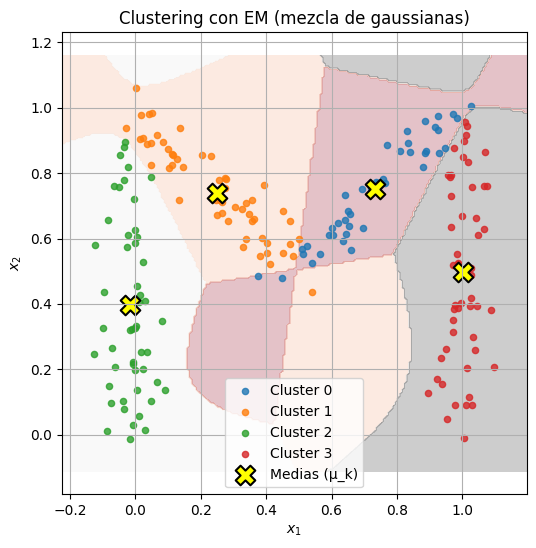

In [344]:
#Entreno el EM
em = EM(K=4, max_iters=100, tol=1e-4,seed=1)
em.fit(X)

print("Centroides (medias) EM:\n", em.mu)
print("Pesos de mezcla:\n", em.pi)

labels_em = em.predict(X)
#Meshgrid como sugeria para armar las fronteras, ahora son mas parecidas a una elipse cada una (mas o menos, es la interpretacion que le doy porque viene de una normal con la covarianza de esa forma)
x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
proba_grid = em.predict_proba(grid)
Z = np.argmax(proba_grid, axis=1).reshape(xx.shape)
#Grafico con contour
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.25, cmap="RdGy")  # fronteras soft
# puntos de datos coloreados
for k in range(em.K):
    pts = X[labels_em == k]
    plt.scatter(pts[:,0], pts[:,1], s=20, alpha=0.8, label=f"Cluster {k}")
# medias
plt.scatter(em.mu[:,0], em.mu[:,1],
            marker='X', s=200, edgecolor='k', linewidth=1.5,
            facecolor='yellow', label='Medias (μ_k)')
plt.title("Clustering con EM (mezcla de gaussianas)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


Se ve que con EM al poder estirarse en la covarianza, puede traer mucho mejor a esas relaciones lineales del manifold en el espacio latente, ahora se dividen mejor los datos por las lineas en tramos y no tanto por cercania a otros puntos como el K means.

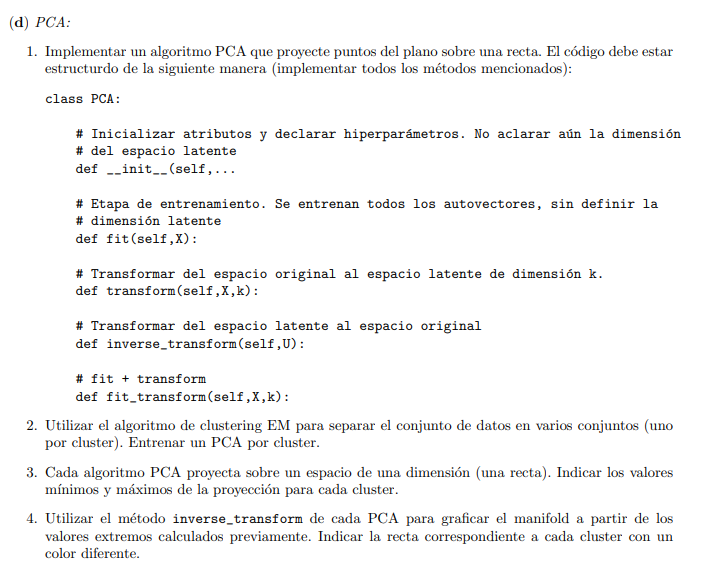

Grafica del PCA del apunte:

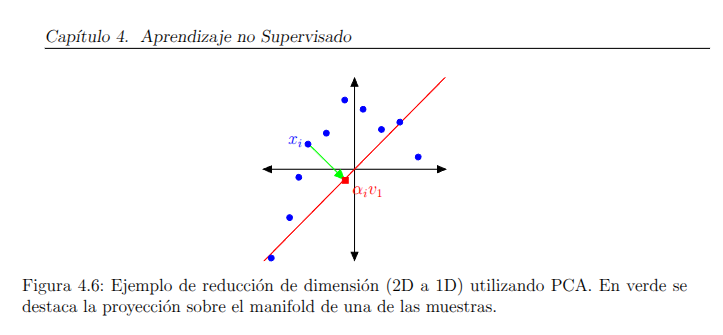

### d. PCA

El Análisis de Componentes Principales (PCA) busca los ejes ortogonales que maximizan la varianza de los datos.  
Dado $ X \in \mathbb{R}^{N \times D} $, se calcula:

$$
\Sigma = \frac{1}{N} (X - \bar{X})^T (X - \bar{X})
$$

y se obtiene la descomposición:

$$
\Sigma v_i = \lambda_i v_i, \qquad \lambda_1 \ge \lambda_2 \ge \dots
$$

Cada  $ v_i $ es un autovector (dirección principal) y cada $\lambda_i$ es su varianza asociada.

---
### **2. PCA local por cluster**

Para cada cluster $ k $  del modelo EM, se entrena un PCA independiente.  
Luego, se proyectan los puntos $  X_i $ del cluster sobre la primera componente principal $ v_{k,1}$

$$
t_i = (X_i - \mu_k)^T v_{k,1}
$$

y se calculan los valores extremos:

$$
t_{\min,k} = \min_i t_i, \qquad
t_{\max,k} = \max_i t_i
$$

---

### **3. Reconstrucción del manifold**

Cada cluster define una recta local en el espacio original:

$$
L_k(t) = \mu_k + t \, v_{k,1}, \qquad t \in [t_{\min,k}, t_{\max,k}]
$$

Estas rectas se grafican con colores distintos, representando los **tramos lineales** del manifold.



In [345]:

class PCA:
    def __init__(self):
        self.mean_ = None       # media de entrenamiento
        self.components_ = None # autovectores ordenados por varianza
        self.eigenvalues_ = None

    def fit(self, X):
        """
        Entrena PCA: calcula autovectores/valores del espacio completo.
        No define aún k (dimensión latente).
        """
        # centrado
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # matriz de covarianza
        cov = np.cov(X_centered, rowvar=False)

        # autovalores y autovectores
        eigvals, eigvecs = np.linalg.eigh(cov)  # eigh porque es simétrica

        # ordenar descendente
        idx = np.argsort(eigvals)[::-1]
        self.eigenvalues_ = eigvals[idx]
        self.components_ = eigvecs[:, idx]

    def transform(self, X, k=1):
        """
        Proyecta X al subespacio de dim k.
        Devuelve las coordenadas latentes (U).
        """
        X_centered = X - self.mean_
        W = self.components_[:, :k]  # (D,k)
        U = X_centered @ W           # (N,k)
        return U

    def inverse_transform(self, U):
        """
        Reconstruye los datos desde las coordenadas latentes U.
        """
        W = self.components_[:, :U.shape[1]]  # (D,k)
        X_rec = U @ W.T + self.mean_
        return X_rec

    def fit_transform(self, X, k=1):
        """
        Fit + Transform en un solo paso.
        """
        self.fit(X)
        return self.transform(X, k)


2. Utilizar el algoritmo de clustering EM para separar el conjunto de datos en varios conjuntos (uno
por cluster). Entrenar un PCA por cluster.
3. Cada algoritmo PCA proyecta sobre un espacio de una dimension (una recta). Indicar los valores
mınimos y maximos de la proyeccion para cada cluster.

Cluster 0: t_min=-0.392, t_max=0.437
Cluster 1: t_min=-0.431, t_max=0.386
Cluster 2: t_min=-0.398, t_max=0.509
Cluster 3: t_min=-0.501, t_max=0.465


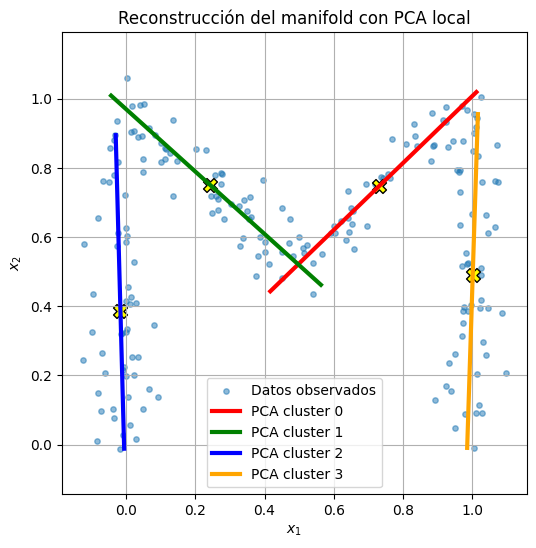

In [346]:
pca_models = []
intervals = []

for k in range(em.K):
    pts_k = X[labels_em == k]
    if len(pts_k) < 2:
        continue

    pca = PCA()
    U_k = pca.fit_transform(pts_k, k=1)
    t_min, t_max = np.min(U_k), np.max(U_k)

    pca_models.append(pca)
    intervals.append((t_min, t_max))

    print(f"Cluster {k}: t_min={t_min:.3f}, t_max={t_max:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], s=15, alpha=0.5, label="Datos observados")

colors = ["r", "g", "b", "orange", "purple"]

for k, (pca, (tmin, tmax)) in enumerate(zip(pca_models, intervals)):

    t_vals = np.linspace(tmin, tmax, 20).reshape(-1, 1) #Levanto 20 puntos entre los limites que encontre antes.
    X_rec = pca.inverse_transform(t_vals)

    plt.plot(X_rec[:,0], X_rec[:,1], color=colors[k % len(colors)],
             linewidth=3, label=f"PCA cluster {k}")
    #media del cluster
    plt.scatter(pca.mean_[0], pca.mean_[1], s=100, edgecolor='k',
                facecolor='yellow', marker='X')

plt.title("Reconstrucción del manifold con PCA local")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


### **Resultados**

- Cada PCA local describe la orientación principal del cluster EM.  
- La unión de las rectas $ L_k $ aproxima el manifold original $ M = \{ g(u) \} $.   

El PCA condicional reconstruye el manifold combinando:
- Clustering probabilístico (EM) para segmentar los datos,
- y reducción lineal (PCA 1D) para describir cada tramo.

Así, el modelo aprende una recta por cluster que representa la estructura subyacente de los datos.

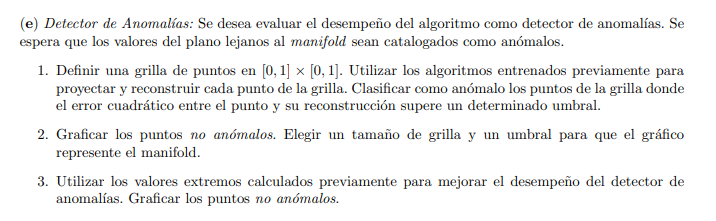

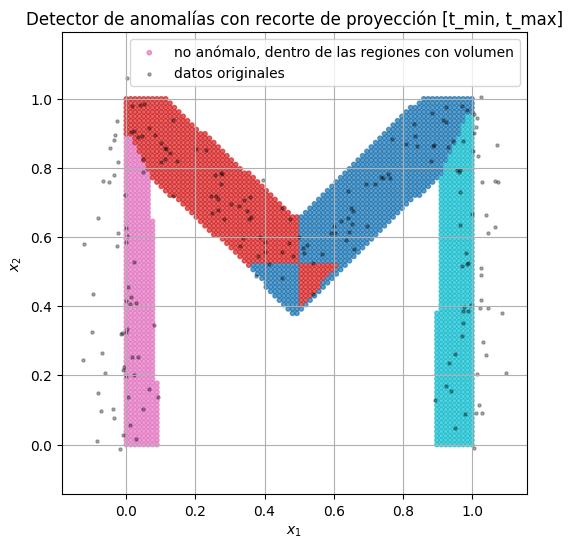

In [347]:
# Lo voy a hacer teniendo en cuenta los tramos válidos [t_min, t_max]
# que calculé antes en el punto (d). Si el punto proyecta fuera de ese
# rango, no lo considero para ese PCA. Esto evita extrapolar y mejora el detector.

errs_clip = np.zeros(len(grid_points))
best_clusters_clip = np.full(len(grid_points), -1)

# Recorro toda la grilla de puntos del plano (igual que antes)
for i, xq in enumerate(grid_points):
    xq = xq.reshape(1, -1)
    best_err = np.inf
    best_k = -1

    # Recorro cada PCA local junto con su rango válido [t_min, t_max]
    for k, (pca, (tmin, tmax)) in enumerate(zip(pca_models, intervals)):
        # Proyecto el punto sobre el eje principal del PCA
        t = pca.transform(xq)
        # Lo reconstruyo (vuelvo al espacio original)
        x_rec = pca.inverse_transform(t)
        # Calculo el error cuadrático
        err2 = np.sum((xq - x_rec)**2)

        # Si la proyección cae fuera del tramo válido, lo descarto
        if t[0, 0] < tmin or t[0, 0] > tmax:
            continue

        # Si el error es menor que el mejor hasta ahora, lo guardo
        if err2 < best_err:
            best_err = err2
            best_k = k

    # Guardo el menor error y el cluster que mejor lo explicó
    errs_clip[i] = best_err
    best_clusters_clip[i] = best_k

# Clasificación con recorte
# Solo me quedo con puntos que cayeron dentro de algún tramo válido
# y además tengan error de reconstrucción menor al umbral.
umbral = 0.01 #Este lo ajuste a mano para endurecer o aflojar el limite para decir que algo es anomalo, depende de la aplicaicon en realidad, no decia ningun criterio en particular la consigna
mask_valid = best_clusters_clip != -1
mask_not_anom_clip = (errs_clip < umbral) & mask_valid

grid_not_anom_clip = grid_points[mask_not_anom_clip]
grid_not_anom_clip_labels = best_clusters_clip[mask_not_anom_clip]

# Gráfico final
# Ahora el manifold debería verse más limpio, sin puntos extrapolados
plt.figure(figsize=(6,6))
plt.scatter(grid_not_anom_clip[:,0], grid_not_anom_clip[:,1],
            c=grid_not_anom_clip_labels, s=10, cmap='tab10', alpha=0.7,
            label="no anómalo, dentro de las regiones con volumen")
plt.scatter(X[:,0], X[:,1], s=5, alpha=0.3, color='k', label="datos originales")
plt.title("Detector de anomalías con recorte de proyección [t_min, t_max]")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


### Conclusión final sobre el detector de anomalías

En este último apartado se implementó el detector de anomalías utilizando los modelos PCA locales obtenidos para cada región del espacio.  
El criterio de detección se basa en el error cuadrático entre cada punto del plano y su reconstrucción a partir del subespacio lineal correspondiente.  
De esta forma, los puntos bien representados por alguna de las componentes locales son clasificados como no anómalos, mientras que los más alejados del manifold se consideran anómalos.

En este caso se resolvieron juntos los puntos (e2) y (e3), ya que al no aplicar el recorte por los valores extremos $[t_{min}, t_{max}]$ se produce una extrapolación que distorsiona el resultado visual.  
En particular, sin el recorte aparecen segmentos que se cruzan, formando una "X" además de los tramos verticales de la "M".  
Esto ocurre porque, al hacer el inverse transform sin limitar $t$, las rectas asociadas a los clusters 2 y 3 se extienden hasta los bordes del plano (aproximadamente hacia los puntos $(1, 0)$ y $(0, 0)$ respectivamente).

Matías mencionó en clase que conviene hacer el análisis y el gráfico con el recorte incluido, ya que así se evita esa extensión artificial y se obtiene una representación más fiel del manifold.  
Con este ajuste, el modelo logra capturar correctamente las zonas observadas, clasificando como anómalos únicamente los puntos que caen fuera de las grillas válidas de cada región.
